In [1]:
import torch, torchvision, cv2
import torchvision.transforms as T
from torchvision.models.detection import MaskRCNN
from PIL import Image, ImageDraw
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '', '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter',
    'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra',
    'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
    'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon',
    'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet',
    'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
    'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

In [3]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [4]:
# Example usage

img_path = '/content/dog.jpg'

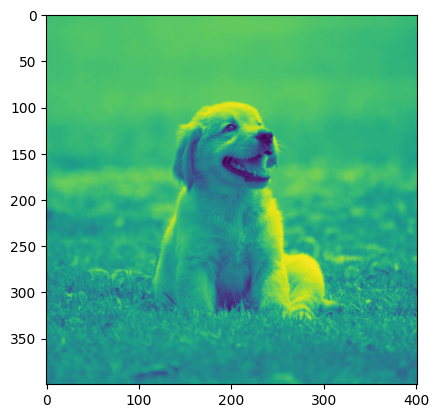

In [5]:
img = cv2.imread(img_path,0)
plt.imshow(img)

In [6]:
# Function to get a prediction

def get_prediction(img_path, threshhold):
  img = Image.open(img_path)
  transform = T.Compose([T.ToTensor()])
  img = transform(img)
  pred = model([img])
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x > threshhold][-1]
  masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
  pred_boxes = [(i[0], i[1], i[2], i[3]) for i in list(pred[0]['boxes'].detach().numpy())]
  masks = masks[:pred_t+1]
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]

  return masks, pred_boxes, pred_class

In [7]:
masks, boxes, category = get_prediction(img_path, 0.5)

In [8]:
boxes

[(113.13939, 95.80373, 307.3694, 340.7187)]

In [9]:
category

['dog']

In [10]:
masks

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])

(<Axes: title={'center': 'Mask Image'}>,
 Text(0.5, 1.0, 'Mask Image'))

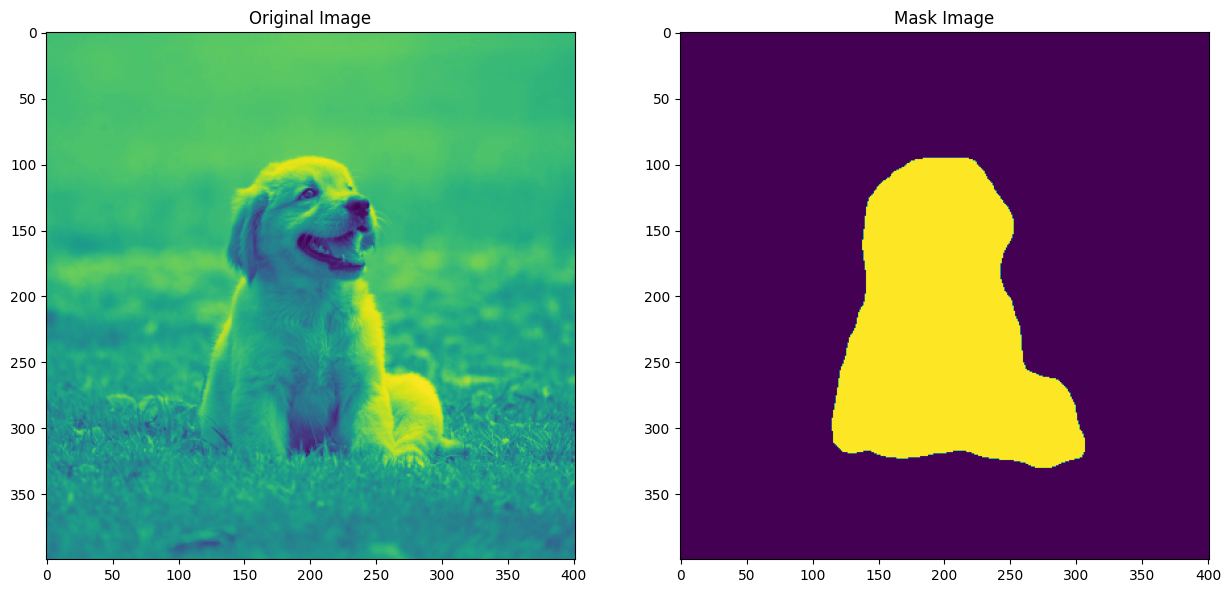

In [11]:
plt.figure(figsize=(15,9))
plt.subplot(121), plt.imshow(img), plt.title('Original Image')
plt.subplot(122), plt.imshow(masks[0]), plt.title('Mask Image')

In [12]:
img.shape

(400, 401)

In [13]:
masks[0].shape

(400, 401)

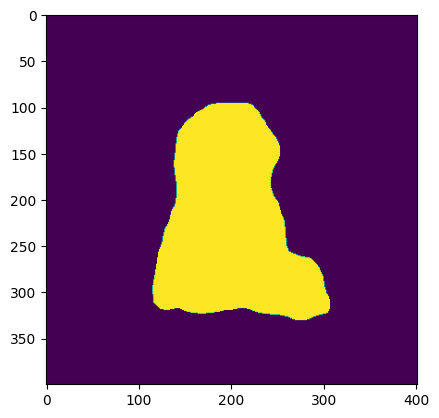

In [14]:
plt.imshow(masks[0])

In [15]:
print(img.dtype)
print(masks[0].dtype)

uint8
bool


In [16]:
masks = (masks[0] * 255).astype(np.uint8)

(<Axes: title={'center': 'Overlapped Image'}>,
 Text(0.5, 1.0, 'Overlapped Image'))

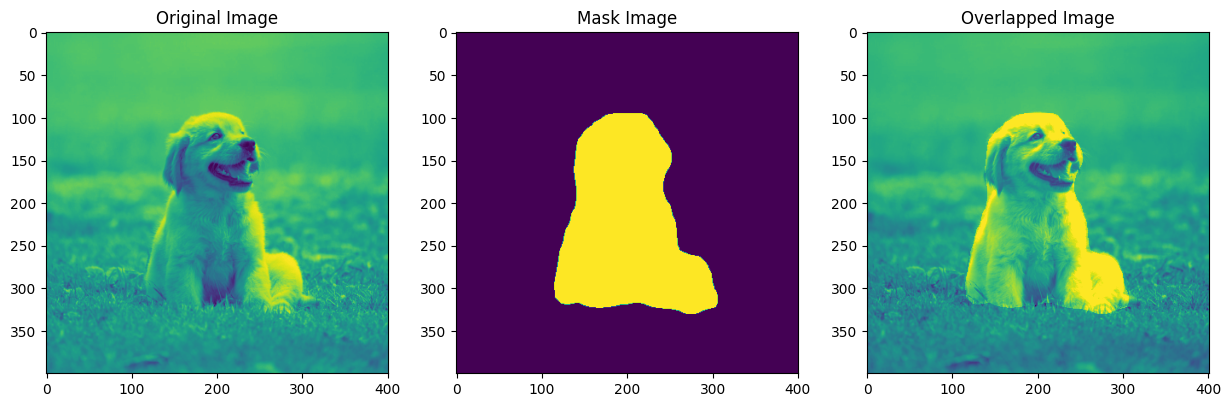

In [17]:
# cv.addWeighted(src1, alpha, src2, beta, gamma dst, dtype): Calculates the weighted sum of two arrays.
'''
src1: first input array.
alpha: weight of the first array elements.
src2: second input array of the same size and channel number as src1.
beta: weight of the second array elements.
gamma: scalar added to each sum.
dst: output array that has the same size and number of channels as the input arrays.
dtype: optional depth of the output array; when both input arrays have the same depth, dtype can be set to -1, which will be equivalent to src1.depth().
'''
result = cv2.addWeighted(img, 1, masks, 0.2, 0)

plt.figure(figsize=(15,9))
plt.subplot(131), plt.imshow(img), plt.title('Original Image')
plt.subplot(132), plt.imshow(masks), plt.title('Mask Image')
plt.subplot(133), plt.imshow(result), plt.title('Overlapped Image')

In [18]:
def random_color_masks(image):
  colours = np.random.randint(0, 255, size=(20, 3), dtype='uint8')
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)

  r[image == 1], g[image == 1], b[image == 1] = colours[random.randint(0, 19)]
  coloured_mask = np.stack([r, g, b], axis = 2)
  return coloured_mask

In [19]:
def find_mask(img_path, threshhold=0.5):
  masks, boxes, category = get_prediction(img_path, threshhold)
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  for i in range(len(masks)):
    rgb_mask = random_color_masks(masks[i])
    img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
  plt.figure(figsize=(15,9))
  plt.imshow(img)

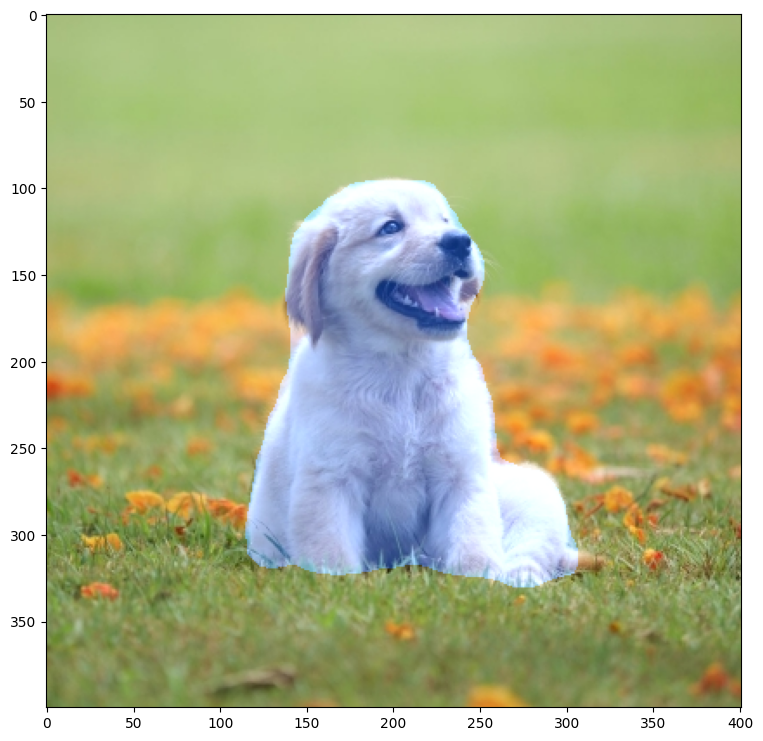

In [20]:
find_mask(img_path)